In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from WassersteinTSNE import GaussianDistribution, plotGaussian, RotationMatrix, MirrorMatrix
from sklearn.decomposition import PCA

import sys
sys.path.insert(0, '../src')
import utils.visualization as vis
import utils.preprocession as prep

## Load Data

In [2]:
candidates = pd.read_csv('../data/candidates.csv', index_col=0)
candidate_reactions = pd.read_csv('../data/candidates_reactions.csv', index_col=0)
voters_reactions = pd.read_csv('../data/voters_reactions.csv', index_col=0)
true_means = pd.read_csv('../data/party_means.csv', index_col=0)
true_stds = pd.read_csv('../data/party_stds.csv', index_col=0)
true_means.head()

,EDU,EVP,FDP,GLP,Grüne,Mitte,SP,SVP,Übrige
32214,0.522222,0.465054,0.979839,0.781046,0.185268,0.503401,0.022222,0.558962,0.278409
32215,0.400000,0.857527,0.108871,0.645425,0.917411,0.675170,0.987037,0.110849,0.615057
32216,0.716667,0.943548,0.673387,0.522876,0.859375,0.933673,0.681481,0.497642,0.784091
32217,0.316667,0.588710,0.899194,0.754902,0.069196,0.693878,0.038889,0.669811,0.264205
32218,0.277778,0.801075,0.197581,0.848039,0.968750,0.744898,0.979630,0.073113,0.569602


In [3]:
gpt_data = pd.read_csv('../results/gpt/2023/gpt4_results.csv', index_col=[0,1])
gpt_data

32214  32215  32216  32217  32218  32219  32220  32221  \
party  temperature                                                           
EDU    1.0           0.25   0.60   0.00   0.00   0.30   0.25   0.00   0.00   
       1.0           0.00   0.50   0.00   0.00   0.30   0.30   0.00   0.00   
       1.0           0.00   0.50   0.50   0.00   0.00   0.30   0.35   0.00   
       1.0           0.00   0.70   0.00   0.00   0.35   0.30   0.00   0.00   
       1.0           0.50   0.50   0.00   0.00   0.40   0.30   0.00   0.00   
...                   ...    ...    ...    ...    ...    ...    ...    ...   
Übrige 2.0           0.52   0.34   0.99   0.00   0.75   0.20   0.57   0.90   
       2.0           0.60   0.50   0.53   0.50   0.80   0.44   0.50   0.10   
       2.0           0.40   0.60   1.00   0.35   0.60   0.60   0.69   0.85   
       2.0           0.50   0.56   0.50   0.20   0.81   0.50   0.60   0.50   
       2.0           0.67   0.40   0.60   0.00   0.00   0.50   0.46   0.50   

                    32222  32223  ...  32279  32280  32281  32282  32283  \
party  temperature                ...                                      
EDU    1.0           0.40   1.00  ...   0.60   0.30   0.50   0.50   0.50   
       1.0           0.00   1.00  ...   0.50   0.20   0.50   0.50   0.50   
       1.0           0.50   1.00  ...   0.85   0.20   0.30   0.50   0.50   
       1.0           0.30   1.00  ...   0.60   0.35   0.50   0.40   0.50   
       1.0           0.20   0.80  ...   0.60   0.30   0.30   0.40   0.50   
...                   ...    ...  ...    ...    ...    ...    ...    ...   
Übrige 2.0           0.20   0.85  ...   0.20   0.72   0.45   1.00   0.26   
       2.0           0.70   0.85  ...   0.30   0.70   0.65   0.80   0.50   
       2.0           0.50   0.70  ...   0.20   0.50   0.78   0.68   1.00   
       2.0           0.45   1.00  ...   0.30   0.74   0.75   0.70   0.58   
       2.0           0.50   1.00  ...   0.20   0.90   0.50   0.75   0.50   

                    32284  32285  32286  32287  32288  
party  temperature                                     
EDU    1.0           0.50   0.50   0.80   0.70    0.3  
       1.0           0.30   0.85   0.70   0.70    0.3  
       1.0           0.50   0.50   0.80   0.75    0.3  
       1.0           0.50   0.60   1.00   0.50    0.3  
       1.0           0.70   0.70   0.80   0.50    0.3  
...                   ...    ...    ...    ...    ...  
Übrige 2.0           0.65   0.50   0.70   0.50    0.5  
       2.0           0.50   0.65   0.70   0.50    0.5  
       2.0           0.50   0.48   0.50   0.37    0.5  
       2.0           0.65   0.50   0.20   0.50    0.5  
       2.0           0.81   0.50   0.75   0.50    0.2  

[450 rows x 75 columns]

In [4]:
gpt_means = gpt_data.groupby(level=0).mean()
gpt_stds = gpt_data.groupby(level=0).std()
gpt_means.head()

,32214,32215,32216,32217,32218,32219,32220,32221,32222,32223,...,32279,32280,32281,32282,32283,32284,32285,32286,32287,32288
party,,,,,,,,,,,,,,,,,,,,,
EDU,0.209400,0.482800,0.189796,0.0180,0.256531,0.3050,0.2046,0.0450,0.376531,0.968367,...,0.5990,0.3284,0.400000,0.4720,0.6056,0.4666,0.5494,0.770204,0.6550,0.2880
EVP,0.274400,0.803200,0.440408,0.1624,0.883400,0.7726,0.5954,0.5452,0.263000,0.620612,...,0.1960,0.9078,0.764286,0.7876,0.5976,0.7674,0.3348,0.581200,0.3370,0.7760
FDP,0.760208,0.352000,0.620000,0.7604,0.424000,0.2540,0.5202,0.2060,0.670400,0.755000,...,0.2484,0.3392,0.362000,0.7266,0.3390,0.4980,0.5730,0.578600,0.5280,0.3284
GLP,0.698600,0.672653,0.504600,0.6762,0.865000,0.5800,0.6616,0.6894,0.383400,0.553400,...,0.1912,0.8672,0.576800,0.8304,0.4364,0.7570,0.3090,0.509000,0.3196,0.7050
Grüne,0.139000,0.904000,0.724600,0.0560,1.000000,0.9340,0.6932,0.8034,0.176200,0.288600,...,0.0850,0.9950,0.848000,0.9390,0.4920,0.9510,0.1400,0.344400,0.1760,0.9130


In [5]:
from scipy.optimize import minimize

def objective(X, Y, i, lambda_):
    term1 = np.sum((X - Y[i])**2)
    term2 = np.mean([np.sum((X - Y[j])**2) for j in range(len(Y)) if j != i])
    return lambda_ * term1 - (1 - lambda_) * term2

def optimize_Yi(Y, i, lambda_):
    # Initial guess (start with Y_i)
    x0 = Y[i]

    # Define bounds for each component of X_i
    bounds = [(0, 1)] * len(x0)

    # Optimization
    result = minimize(objective, x0, args=(Y, i, lambda_), method='L-BFGS-B', bounds=bounds)
    
    return result.x

lambda_ = .3  # Balance factor
extreme_points = []
for i in range(len(gpt_means)):
    optimized_Xi = optimize_Yi(gpt_means.values, i, lambda_)
    extreme_points.append(optimized_Xi)
extreme_points = pd.DataFrame(extreme_points, index=gpt_means.index, columns=gpt_means.columns)
extreme_points

,32214,32215,32216,32217,32218,32219,32220,32221,32222,32223,...,32279,32280,32281,32282,32283,32284,32285,32286,32287,32288
party,,,,,,,,,,,,,,,,,,,,,
EDU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
EVP,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
FDP,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
GLP,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
Grüne,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
Mitte,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
SP,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
SVP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
Übrige,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [6]:
extreme_points.loc['Übrige'] = np.ones(75)*0.5

In [7]:
pca = PCA(n_components=2)
Xc = pca.fit_transform(candidate_reactions)
Xv = pca.transform(voters_reactions)
Xg = pca.transform(gpt_data.fillna(.5))
Xe = pca.transform(extreme_points)

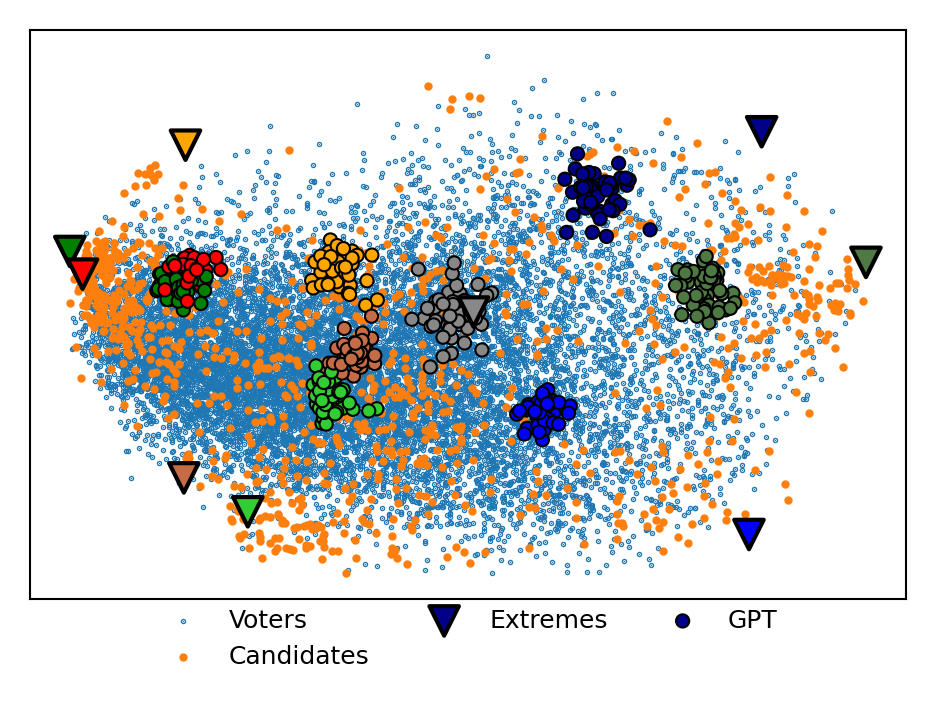

In [8]:
fig, ax = plt.subplots(figsize=(vis.columnwidth, 2*vis.columnwidth))
ax.scatter(Xv[:,0], Xv[:,1], s=.1, lw=None, label='Voters')
ax.scatter(Xc[:,0], Xc[:,1], s=1, label='Candidates')
colors = extreme_points.index.get_level_values(0).map(vis.party_colors)
ax.scatter(Xe[:,0], Xe[:,1], s=50,marker='v', c=colors, label='Extremes', edgecolors='black', zorder=10)
colors = gpt_data.index.get_level_values(0).map(vis.party_colors)
ax.scatter(Xg[:,0], Xg[:,1], s=10, lw=0.5, c=colors, edgecolors='black',label='GPT')
ax.set_aspect('equal')
legend = ax.legend(loc='center', bbox_to_anchor=(.5, -.07), ncol=3, borderaxespad=0.,
                   frameon=False)
ax.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
fig.tight_layout()


In [9]:
results = pd.read_csv('../data/results_zh.csv', index_col=0)
results['Adjusted'] = results['Stimmen%']
results.loc['Übrige', 'Adjusted'] = 30
results = results.loc[gpt_means.index]/results.loc[gpt_means.index].sum(axis=0)
results

,Stimmen%,Adjusted
party,,
EDU,0.014901,0.011852
EVP,0.028403,0.022590
FDP,0.124512,0.099030
GLP,0.123712,0.098393
Grüne,0.099310,0.078985
Mitte,0.081508,0.064827
SP,0.211421,0.168151
SVP,0.273527,0.217547
Übrige,0.042704,0.238626


In [10]:
initial_weights = results['Adjusted'].values.flatten()
initial_weights = results['Stimmen%'].values.flatten()
if np.sum(initial_weights) != 1 or np.any(initial_weights <= 0):
    raise ValueError("Initial weights must sum to 1 and be positive")
# Generate samples from the Dirichlet distribution
samples = prep.generator.dirichlet(initial_weights, size=12000)
# np.random.dirichlet(initial_weights, num_samples=12000)
results['simulation'] = samples.mean(axis=0)
results

,Stimmen%,Adjusted,simulation
party,,,
EDU,0.014901,0.011852,0.014727
EVP,0.028403,0.022590,0.032089
FDP,0.124512,0.099030,0.123342
GLP,0.123712,0.098393,0.123992
Grüne,0.099310,0.078985,0.098833
Mitte,0.081508,0.064827,0.079389
SP,0.211421,0.168151,0.212184
SVP,0.273527,0.217547,0.272254
Übrige,0.042704,0.238626,0.043190


In [11]:
weighted_averages = np.dot(samples, extreme_points)
weighted_averages = pd.DataFrame(weighted_averages, columns=gpt_data.columns)
weighted_averages

,32214,32215,32216,32217,32218,32219,32220,32221,32222,32223,...,32279,32280,32281,32282,32283,32284,32285,32286,32287,32288
0,0.304503,7.441893e-01,0.935867,0.289062,7.441893e-01,7.219479e-01,7.441893e-01,7.441893e-01,0.255811,0.255811,...,0.015441,7.441893e-01,7.219479e-01,0.984559,0.708206,7.441893e-01,0.282262,0.041892,0.255811,7.441893e-01
1,0.979717,5.067436e-02,0.050009,0.060118,5.067436e-02,2.051244e-02,5.067436e-02,5.067436e-02,0.949326,0.949326,...,0.919600,5.067436e-02,2.051244e-02,0.080400,0.939882,5.067436e-02,0.949555,0.919829,0.949326,5.067436e-02
2,0.039989,9.600244e-01,0.960069,0.000071,9.600244e-01,9.600244e-01,9.600244e-01,9.600244e-01,0.039976,0.039976,...,0.039918,9.600244e-01,9.600244e-01,0.960082,0.235580,9.600244e-01,0.039989,0.039931,0.039976,9.600244e-01
3,0.785911,2.155802e-01,0.214099,0.004880,2.155802e-01,2.142798e-01,2.155802e-01,2.155802e-01,0.784420,0.784420,...,0.784409,2.155802e-01,2.142798e-01,0.215591,0.953009,2.155802e-01,0.784611,0.784600,0.784420,2.155802e-01
4,0.024064,9.759363e-01,0.991787,0.023833,9.759363e-01,9.759363e-01,9.759363e-01,9.759363e-01,0.024064,0.024064,...,0.008213,9.759363e-01,9.759363e-01,0.991787,0.855863,9.759363e-01,0.024064,0.008213,0.024064,9.759363e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.390822,9.248627e-01,0.670440,0.376947,9.248627e-01,6.091778e-01,9.248627e-01,9.248627e-01,0.075137,0.075137,...,0.013875,9.248627e-01,6.091778e-01,0.986125,0.397526,9.248627e-01,0.075137,0.013875,0.075137,9.248627e-01
11996,1.000000,5.099339e-08,0.222061,0.222061,5.099339e-08,1.541182e-08,5.099339e-08,5.099339e-08,1.000000,1.000000,...,0.777939,5.099339e-08,1.541182e-08,0.222061,0.777939,5.099339e-08,1.000000,0.777939,1.000000,5.099339e-08
11997,0.999930,9.518880e-01,0.045026,0.996775,9.518880e-01,3.920208e-02,9.518880e-01,9.518880e-01,0.048112,0.048112,...,0.003156,9.518880e-01,3.920208e-02,0.996844,0.003225,9.518880e-01,0.087244,0.042288,0.048112,9.518880e-01
11998,0.973365,6.013190e-01,0.026714,0.601399,6.013190e-01,6.013152e-01,6.013190e-01,6.013190e-01,0.398681,0.398681,...,0.398601,6.013190e-01,6.013152e-01,0.601399,0.398601,6.013190e-01,0.973362,0.973282,0.398681,6.013190e-01


In [12]:
pca = PCA(n_components=2)
Xc = pca.fit_transform(candidate_reactions)
Xv = pca.transform(weighted_averages)
Xg = pca.transform(gpt_data.fillna(.5))
Xe = pca.transform(extreme_points)

Figure size in inches: [226.147  203.5323]
Aspect ratio of the figure: 0.8999999999999999


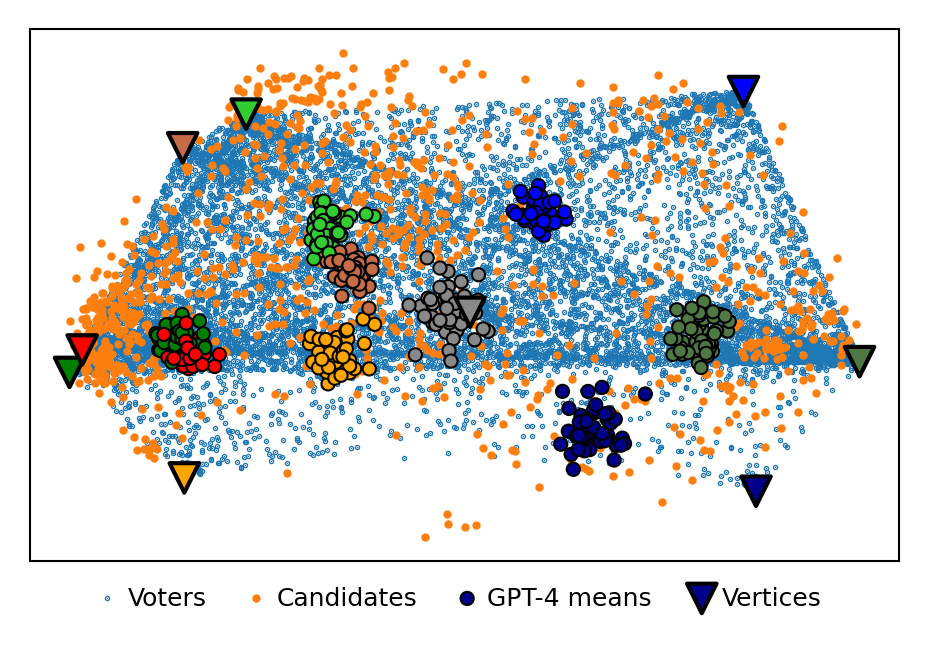

In [ ]:
fig, ax = plt.subplots(figsize=(vis.columnwidth, .9*vis.columnwidth))
ax.scatter(Xv[:,0], -Xv[:,1], s=.1, lw=None, label='Voters')
ax.scatter(Xc[:,0], -Xc[:,1], s=1, label='Candidates')
colors = gpt_data.index.get_level_values(0).map(vis.party_colors)
ax.scatter(Xg[:,0], -Xg[:,1], s=10, lw=0.5, c=colors, edgecolors='black',label='GPT-4 means')
colors = extreme_points.index.get_level_values(0).map(vis.party_colors)
ax.scatter(Xe[:,0], -Xe[:,1], s=50,marker='v', c=colors, label='Vertices', edgecolors='black', zorder=10)
ax.set_aspect('equal')
legend = ax.legend(loc='center', bbox_to_anchor=(.5, -.07), ncol=4, borderaxespad=0.,
                   frameon=False,
                handlelength=0,
                labelspacing=-1
                   )
ax.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
fig.tight_layout()

# Print the size of the figure
print("Figure size in inches:", fig.get_size_inches()/vis.inches_pt)
print("Aspect ratio of the figure:", fig.get_figheight()/fig.get_figwidth())

In [14]:
weighted_averages.to_csv('../data/gpt_voters.csv')

In [ ]:
samples = pd.DataFrame(samples, columns=gpt_means.index)
samples.to_csv('../data/gpt_voters_weights.csv')
samples.mean()

party
EDU       0.014727
EVP       0.032089
FDP       0.123342
GLP       0.123992
Grüne     0.098833
Mitte     0.079389
SP        0.212184
SVP       0.272254
Übrige    0.043190
dtype: float64

In [ ]:
extreme_points.to_csv('../data/gpt_voters_vertices.csv')